# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [18]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [119]:
def P1(num_examples=5):
### STUDENT START ###
  for i in range(num_examples):
        print 'Example {0}:\ntext: {1}\nlabel: {2}\n' \
        .format(i, train_data[i], newsgroups_train.target_names[train_labels[i]])
### STUDENT END ###
P1()

Example 0:
text: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
label: comp.graphics

Example 1:
text: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
label

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [120]:
def P2():
### STUDENT START ###
    
    print "Question A:"
    cv = CountVectorizer()
    train_counts = cv.fit_transform(train_data)
    print "Size of vocabulary: {0}".format(len(cv.vocabulary_))
    # Compute num non-zero features per row using axis=1, then take average all values.
    print "Average number of non-zero features per example: {0}".format(np.average(train_counts.getnnz(axis=1)))
    # Compute num entries = num rows * num columns.
    num_entries = train_counts.shape[0] * train_counts.shape[1]
    # Compute total non-zero entries / num entries.
    print "Fraction of non-zero entries: {0}".format(float(train_counts.nnz) / num_entries)
    
    print "\nQuestion B:"
    feature_names = cv.get_feature_names()
    print "0th feature: {0}".format(feature_names[0])
    print "Last feature: {0}".format(feature_names[len(feature_names) - 1])
    
    print "\nQuestion C:"
    cv2 = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"])
    train_counts2 = cv2.fit_transform(train_data)
    print "Training vector dimensions: {0}".format(train_counts2.shape)
    print "Average number of non-zero features per example: {0}".format(np.average(train_counts2.getnnz(axis=1)))
    
    print "\nQuestion D:"
    # Extract bigram and trigram character features.
    cv3 = CountVectorizer(analyzer="char_wb", ngram_range=(2,3))
    cv3.fit(train_data)
    print "Vocabulary size: {0}".format(len(cv3.vocabulary_))
    
    print "\nQuestion E:"
    cv4 = CountVectorizer(min_df=10)
    cv4.fit(train_data)
    print "Vocabulary size: {0}".format(len(cv4.vocabulary_))
    
    print "\nQuestion F:"
    cv5 = CountVectorizer()
    cv5.fit(train_data)
    cv6 = CountVectorizer()
    cv6.fit(dev_data)
    # Use sets to compute difference in order to remove duplicate words.
    train_dict_set = set(cv5.vocabulary_.keys())
    dev_dict_set = set(cv6.vocabulary_.keys())
    set_diff_1 = train_dict_set.difference(dev_dict_set)
    set_diff_2 = dev_dict_set.difference(train_dict_set)
    print "Num words in train data but not in dev data: {0}".format(len(set_diff_1))
    print "Fraction of words in train data missing from dev vocabulary: {0}" \
    .format(float(len(set_diff_1)) / float(len(train_dict_set)))
    print "Num words in dev data but not in train data: {0}".format(len(set_diff_2))
    print "Fraction of words in dev data missing from train vocabulary: {0}" \
    .format(float(len(set_diff_2)) / float(len(dev_dict_set)))

    
### STUDENT END ###
P2()

Question A:
Size of vocabulary: 26879
Average number of non-zero features per example: 96.7059980334
Fraction of non-zero entries: 0.00359782722696

Question B:
0th feature: 00
Last feature: zyxel

Question C:
Training vector dimensions: (2034, 4)
Average number of non-zero features per example: 0.268436578171

Question D:
Vocabulary size: 28954

Question E:
Vocabulary size: 3064

Question F:
Num words in train data but not in dev data: 14660
Fraction of words in train data missing from dev vocabulary: 0.545407195208
Num words in dev data but not in train data: 4027
Fraction of words in dev data missing from train vocabulary: 0.247876400345


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [81]:
def P3():
### STUDENT START ###
    # Create training feature set.
    cv = CountVectorizer();
    train_features = cv.fit_transform(train_data)
    dev_features = cv.transform(dev_data)

    # Compute optimal k for k nearest neighbors using GridSearchCV.
    n_neighbors = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
    gs_knn = GridSearchCV(KNeighborsClassifier(), n_neighbors, scoring='f1_weighted')
    gs_knn.fit(train_features, train_labels)
    best_k = gs_knn.best_params_['n_neighbors']
    print "K-Nearest Neighbors Classifier:"
    print "  Optimal k for k nearest neighbors classifier: {0}".format(best_k)
    
    # Fit KNN using optimal k.
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(train_features, train_labels)
    knn_predictions = knn.predict(dev_features)
    print "  F1 score: {0}".format(metrics.f1_score(dev_labels, knn_predictions, average='weighted'))
    
    # Compute optimal alpha for multinomial nb using GridSearchCV
    alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    gs_nb = GridSearchCV(MultinomialNB(), alphas, scoring='f1_weighted')
    gs_nb.fit(train_features, train_labels)
    best_alpha = gs_nb.best_params_['alpha']
    print "\nMultinomial Naive Bayes Classifier:"
    print "  Optimal alpha for multinomial naive bayes classifier: {0}".format(best_alpha)
    
    # Fit multinomial nb using optimal alpha.
    nb = MultinomialNB(alpha=best_alpha)
    nb.fit(train_features, train_labels)
    nb_predictions = nb.predict(dev_features)
    print "  F1 score: {0}".format(metrics.f1_score(dev_labels, nb_predictions, average='weighted'))
    
    # Compute optimal C for logistic regression model using l2 regularization using GridSearchCV.
    c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    gs_lr = GridSearchCV(LogisticRegression(penalty='l2'), {'C': c_values}, scoring='f1_weighted')
    gs_lr.fit(train_features, train_labels)
    best_c = gs_lr.best_params_['C']
    print "\nLogistic Regression Classifier:"
    print "  Optimal C for logistic regression classifier using l2 regularization: {0}".format(best_c)
    
    # Fit logistic regression model using l2 regularization with optimal C.
    lr = LogisticRegression(C=best_c, penalty='l2')
    lr.fit(train_features, train_labels)
    lr_predictions = lr.predict(dev_features)
    print "  F1 score: {0}".format(metrics.f1_score(dev_labels, lr_predictions, average='weighted'))
    
    # Compute sum of the squared weight values for each class for each setting of the C parameter.
    print "\n Part C:"
    for c in c_values:
        lr_c = LogisticRegression(C=c, penalty='l2')
        lr_c.fit(train_features, train_labels)
        sum_squared = np.sum(lr_c.coef_**2, axis=1)
        print "  Sum of squared weight values for C={0}: {1}".format(c, sum_squared)

### STUDENT END ###
P3()

K-Nearest Neighbors Classifier:
  Optimal k for k nearest neighbors classifier: 12
  F1 score: 0.421102636139

Multinomial Naive Bayes Classifier:
  Optimal alpha for multinomial naive bayes classifier: 0.01
  F1 score: 0.775166321854

Logistic Regression Classifier:
  Optimal C for logistic regression classifier using l2 regularization: 0.1
  F1 score: 0.696624354242

 Part C:
  Sum of squared weight values for C=0.001: [ 0.16509345  0.20095275  0.18067094  0.18724278]
  Sum of squared weight values for C=0.01: [ 2.54151724  2.93970937  2.86246916  2.25002876]
  Sum of squared weight values for C=0.1: [ 27.12791582  24.65940433  27.45869631  23.0245062 ]
  Sum of squared weight values for C=1: [ 166.97755478  130.90016943  157.95888557  145.74392086]
  Sum of squared weight values for C=10: [ 585.51390405  448.37657831  538.39646139  530.83306687]
  Sum of squared weight values for C=100: [ 1402.92524901  1098.01011617  1304.32674838  1323.53271471]
  Sum of squared weight values for 

ANSWER:  
a. K nearest neighbors doesn't work well because the data is so sparse and many features have very few occurances. This means that looking at the nearest neighbors is not very helpful.  
  
b. Naive Bayes works well because of the independence assumption that aligns well with the bag of words approach where all the features are treated independently by only taking into account the frequencies of each word. Logistic regression on the other hand does not work as well because it takes into account relationships between the features through linear models.  
  
c. As C gets bigger, the sum of squared weight values increases. This is because the larger the regularization parameter (C), the more it reduces overfitting by reducing the variance of the weights and biasing the estimates.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [121]:
def P4():
### STUDENT START ###
    # Create training feature set with unigram features.
    cv_train_uni = CountVectorizer();
    train_features_uni = cv_train_uni.fit_transform(train_data)
    
    lr_uni = LogisticRegression(penalty='l2', C=0.3)
    lr_uni.fit(train_features_uni, train_labels)
    print 'Unigram top features weight table:'
    GetFeatureTable(cv_train_uni.get_feature_names(), lr_uni.coef_)
    
    
    # Create training feature set with bigram word features.
    cv_train_bi = CountVectorizer(analyzer="word", ngram_range=(2,2));
    train_features_bi = cv_train_bi.fit_transform(train_data)
    
    lr_bi = LogisticRegression(penalty='l2', C=0.3)
    lr_bi.fit(train_features_bi, train_labels)
    print '\nBigram top features weight table:'
    GetFeatureTable(cv_train_bi.get_feature_names(), lr_bi.coef_)

def GetFeatureTable(feature_names, coef):
    top_20_features_indicies = []
    for label, features in enumerate(coef):
        sorted_features = np.sort(features)
        top_5 = sorted_features[len(sorted_features) - 5:]
        for value in top_5:
            top_20_features_indicies.append(features.tolist().index(value))
    
    print "Feature: \t{0}".format(newsgroups_train.target_names)
    for i, feature_index in enumerate(top_20_features_indicies):
        feature_name = feature_names[feature_index]
        feature_weights = [round(coef[label, feature_index], 4) for label in range(coef.shape[0])]
        print "{0}:\t\t{1}".format(feature_name, feature_weights)

### STUDENT END ###
P4()

Unigram top features weight table:
Feature: 	['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
islam:		[0.5914, -0.0981, -0.244, -0.2469]
atheism:		[0.6927, -0.3047, -0.3097, -0.3398]
religion:		[0.6931, -0.4351, -0.5679, -0.0344]
atheists:		[0.702, -0.0903, -0.2305, -0.5096]
bobby:		[0.7075, -0.1689, -0.2468, -0.3338]
computer:		[0.0251, 0.7516, -0.4887, -0.3367]
3d:		[-0.2631, 0.8109, -0.4812, -0.2728]
file:		[-0.2389, 0.9158, -0.5952, -0.4284]
image:		[-0.395, 0.9555, -0.5659, -0.3226]
graphics:		[-0.5617, 1.4135, -0.9452, -0.5364]
spacecraft:		[-0.2558, -0.274, 0.614, -0.2354]
launch:		[-0.3171, -0.347, 0.679, -0.2433]
nasa:		[-0.3956, -0.361, 0.7438, -0.3532]
orbit:		[-0.3055, -0.4827, 0.8689, -0.4099]
space:		[-0.923, -0.9777, 1.6596, -0.8386]
order:		[-0.5492, -0.056, -0.1088, 0.6341]
fbi:		[-0.2007, -0.1794, -0.3233, 0.6431]
blood:		[-0.3536, -0.087, -0.1786, 0.7035]
christians:		[-0.5136, -0.258, -0.3293, 0.7789]
christian:		[-0.4015, -0.2867, -0.2333, 0.7936

ANSWER:  
I found that many of these top features are not very meaningful, especially when looking at the bigrams. Many of these word pairs are just commonly used verbs that don't have much meaning such as "are you" and "it was". Additionally, "cheers kent" showed up in the top 5 for two different labels which is also extremely surprising because it seems like an email signature.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [115]:
def empty_preprocessor(s):
   return s

def better_preprocessor(s):
### STUDENT START ###
    # Convert all text to lowercase.
    s = s.lower()
    # Replace line breaks with whitespace.
    s = re.sub('\n', ' ', s)
    # Remove non-letter characters.
    s = re.sub('[^a-zA-Z\d\s]{1}', '', s)
    # Replace sequences of numbers with a * token.
    s = re.sub('\d\d+','*', s)
    # Truncate words longer than 5 char and throw out words shorter than 3 char.
    words = []
    for word in s.split(" "):
        if len(word) > 5:
            words.append(word[:5])
        elif len(word) < 3:
            # Throw out word.
            continue;
        else:
            words.append(word)
    return " ".join(words)
### STUDENT END ###

def P5():
### STUDENT START ###
    # Create training feature set with empty preprocessor.
    cv_empty = CountVectorizer(preprocessor=empty_preprocessor);
    train_features_empty = cv_empty.fit_transform(train_data)
    dev_features_empty = cv_empty.transform(dev_data)
    
    # Train logistic regression model.
    lr_empty = LogisticRegression(penalty='l2')
    lr_empty.fit(train_features_empty, train_labels)
    lr_predictions_empty = lr_empty.predict(dev_features_empty)
    print "Empty preprocessor:"
    print "  Size of vocabulary: {0}".format(len(cv_empty.vocabulary_))
    print "  F1 score: {0}".format(metrics.f1_score(dev_labels, lr_predictions_empty, average='weighted'))

    # Create training feature set with better preprocessor.
    cv_better = CountVectorizer(preprocessor=better_preprocessor);
    train_features_better = cv_better.fit_transform(train_data)
    dev_features_better = cv_better.transform(dev_data)
    
    # Train logistic regression model.
    lr_better = LogisticRegression(penalty='l2')
    lr_better.fit(train_features_better, train_labels)
    lr_predictions_better = lr_better.predict(dev_features_better)
    print "\nBetter preprocessor:"
    print "  Size of vocabulary: {0}".format(len(cv_better.vocabulary_))
    print "  F1 score: {0}".format(metrics.f1_score(dev_labels, lr_predictions_better, average='weighted'))
    
### STUDENT END ###
P5()

Empty preprocessor:
  Size of vocabulary: 33291
  F1 score: 0.702334008756

Better preprocessor:
  Size of vocabulary: 15582
  F1 score: 0.712907383142


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).


C used: 0.001
  L1 Regularization # non-zero learned weights: 7
  L2 Regularization # non-zero learned weights: 107516
  L2 Regularization # non-zero learned weights with trimmed feature set: 16
  Accuracy: 0.397928994083
  Trimmed feature set size: 4

C used: 0.01
  L1 Regularization # non-zero learned weights: 49
  L2 Regularization # non-zero learned weights: 107516
  L2 Regularization # non-zero learned weights with trimmed feature set: 88
  Accuracy: 0.498520710059
  Trimmed feature set size: 22

C used: 0.1
  L1 Regularization # non-zero learned weights: 462
  L2 Regularization # non-zero learned weights: 107516
  L2 Regularization # non-zero learned weights with trimmed feature set: 1036
  Accuracy: 0.692307692308
  Trimmed feature set size: 259

C used: 1
  L1 Regularization # non-zero learned weights: 3592
  L2 Regularization # non-zero learned weights: 107516
  L2 Regularization # non-zero learned weights with trimmed feature set: 7636
  Accuracy: 0.701183431953
  Trimmed fe

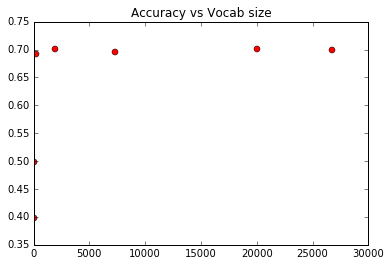

In [122]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    # Create list of different C values to use.
    c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    accuracies = []
    vocab_size = []
    for c in c_values:
        # Call TrainModel method for each c value to compute accuracy and trimmed vocab size.
        pair = TrainModel(c)
        accuracies.append(pair[0])
        vocab_size.append(pair[1])
    # Plot graph showing accuracy of re-trained model vs trimmed vocab size.
    plt.title('Accuracy vs Vocab size')
    plt.plot(vocab_size, accuracies, 'ro')
    
def TrainModel(c):
    print "\nC used: {0}".format(c)
    # Create training feature set.
    cv = CountVectorizer();
    train_features = cv.fit_transform(train_data)
    dev_features = cv.transform(dev_data)
    
    # Train logistic regression model with L1 regularization.
    lr_l1 = LogisticRegression(C=c, penalty='l1', tol=0.1)
    lr_l1.fit(train_features, train_labels)
    print "  L1 Regularization # non-zero learned weights: {0}".format(np.count_nonzero(lr_l1.coef_))
    
    # Train logistic regression model with L2 regularization.
    lr_l2 = LogisticRegression(C=c, penalty='l2', tol=0.1)
    lr_l2.fit(train_features, train_labels)
    print "  L2 Regularization # non-zero learned weights: {0}".format(np.count_nonzero(lr_l2.coef_))
    
    # Prune unused features from training features and dev features.
    used_features = []
    feature_names = cv.get_feature_names()
    # Compute sum of each column.
    sum_columns = lr_l1.coef_.sum(0)
    for i, sum in enumerate(sum_columns):
        # Keep feature if sum is non-zero, meaning at least one feature has a non-zero weight.
        if sum != 0:
            used_features.append(feature_names[i])

    # Create new CountVectorizer with trimmed vocabulary.
    cv_trimmed = CountVectorizer(vocabulary=used_features)
    train_features_trimmed = cv_trimmed.fit_transform(train_data)
    dev_features_trimmed = cv_trimmed.transform(dev_data)
    
    # Retrain logistic regression model with L2 regularization and trimmed feature set.
    lr_l2 = LogisticRegression(penalty='l2')
    lr_l2.fit(train_features_trimmed, train_labels)
    
    # Compute accuracy
    accuracy = lr_l2.score(dev_features_trimmed, dev_labels)
    print "  L2 Regularization # non-zero learned weights with trimmed feature set: {0}" \
    .format((lr_l2.coef_ != 0).sum())
    print "  Accuracy: {0}".format(accuracy)
    print "  Trimmed feature set size: {0}".format(len(used_features))
    
    return (accuracy, len(used_features))
    
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [124]:
def P7():
### STUDENT START ###
    # Create training feature set.
    tfv = TfidfVectorizer();
    train_features = tfv.fit_transform(train_data)
    dev_features = tfv.transform(dev_data)
    
    # Train logistic regression model with L2 regularization.
    lr = LogisticRegression(C=100, penalty='l2', tol=0.1)
    lr.fit(train_features, train_labels)
    predictions = lr.predict(dev_features)
    predicted_prob = lr.predict_proba(dev_features)
    # Create a dictionary mapping from r value to index of example.
    r_values = {}
    for i in range(predicted_prob.shape[0]):
        # Compute R = max pred prob / pred prob of correct label.
        max_pred_prob = np.max(predicted_prob[i])
        correct_pred_prob = predicted_prob[i, dev_labels[i]]
        r = float(max_pred_prob) / correct_pred_prob
        r_values[r] = i
    # Sort r_values to get largest 3 values.
    sorted_r_values = np.sort(r_values.keys())
    # Iterate over largest 3 R values.
    for r_value in sorted_r_values[len(sorted_r_values) - 3:]:
        print "R value: {0}".format(r_value)
        example_index = r_values[r_value]
        print "Predicted label: {0}".format(newsgroups_train.target_names[predictions[example_index]])
        print "Actual label: {0}".format(newsgroups_train.target_names[dev_labels[example_index]])
        print "Document contents:\n\n{0}".format(dev_data[example_index])
        print "\n"
    
    # Print out confusion matrix to see most commonly confused labels.
    cm = confusion_matrix(dev_labels, predictions)
    print 'Confusion matrix:'
    print cm
        
## STUDENT END ###
P7()

R value: 132.991642928
Predicted label: talk.religion.misc
Actual label: alt.atheism
Document contents:

With the Southern Baptist Convention convening this June to consider
the charges that Freemasonry is incompatible with christianity, I thought
the following quotes by Mr. James Holly, the Anti-Masonic Flag Carrier,
would amuse you all...

     The following passages are exact quotes from "The Southern 
Baptist Convention and Freemasonry" by James L. Holly, M.D., President
of Mission and Ministry To Men, Inc., 550 N 10th St., Beaumont, TX 
77706. 
 
     The inside cover of the book states: "Mission & Ministry to Men, 
Inc. hereby grants permission for the reproduction of part or all of 
this booklet with two provisions: one, the material is not changed and
two, the source is identified." I have followed these provisions. 
  
     "Freemasonry is one of the allies of the Devil" Page iv. 
 
     "The issue here is not moderate or conservative, the issue is God
and the Devil" Page vi."

ANSWER:  
TfidfVectorizer is different from CountVectorizer because rather than taking occurance counts, which have issues with longer documents having higher average count values than shorter documents, the TfidfVectorizer divides the number of occurrences of each word in the document by the total number of words in the document to compute term frequencies.

From looking at the confusion matrix, one possible issue the model struggles with is dealing with differentiating between alt.atheism and talk.religion.misc. This is evident by the earlier analysis of top words for each label where atheism had many words "religion" in it's top 5 features. Another issue is that transmission details such as FTP information confuse the model as well. One way to improve the model could be to remove all FTP or email information to reduce the noise leading to misclassifications as comp.graphics. Other options might be to use stop words to remove commonly used words or to look at using bigram words to improve overall accuracy.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.